In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wholesale-customers-data-set/Wholesale customers data.csv


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import boxcox

# CSCA 5632 Final
**Alexandra Zenteno**

This project will explore data involving clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories. I will be using the dataset from UCI Wholesale Customers Data Set.

The goal is to utilize unsuperised learning algorithms, specifically PCA and Hierachical Clustering to find any patterns from clients.


## Part 1: Exploratory Data Analysis (EDA)

We will begin by importing necessary tools to perform EDA and data cleaning.

**Additional Variable Information**
This informations comes from the UCI dataset and has more information regarding each columns and what their data represents.

1)	FRESH: annual spending (m.u.) on fresh products (Continuous);
2)	MILK: annual spending (m.u.) on milk products (Continuous);
3)	GROCERY: annual spending (m.u.)on grocery products (Continuous);
4)	FROZEN: annual spending (m.u.)on frozen products (Continuous)
5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
7)	CHANNEL: customer Channel - Horeca (Hotel/Restaurant/Cafes) or Retail channel (Nominal)
8)	REGION: customer Region: Lisnon, Oporto or Other (Nominal)
Descriptive Statistics:

	(Minimum, Maximum, Mean, Std. Deviation)
FRESH (	3, 112151, 12000.30, 12647.329)
MILK	(55, 73498, 5796.27, 7380.377)
GROCERY	(3, 92780, 7951.28, 9503.163)
FROZEN	(25, 60869, 3071.93, 4854.673)
DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
DELICATESSEN (3, 47943, 1524.87, 2820.106)



In [84]:
#importing data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("binovi/wholesale-customers-data-set")

# Load the dataset
df = pd.read_csv("/kaggle/input/wholesale-customers-data-set/Wholesale customers data.csv")

#print dataframe head for sanity check
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [85]:
#gather information regarding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Here, we see that this dataset has 440 entries and 8 columns, for a shape of (440,8)

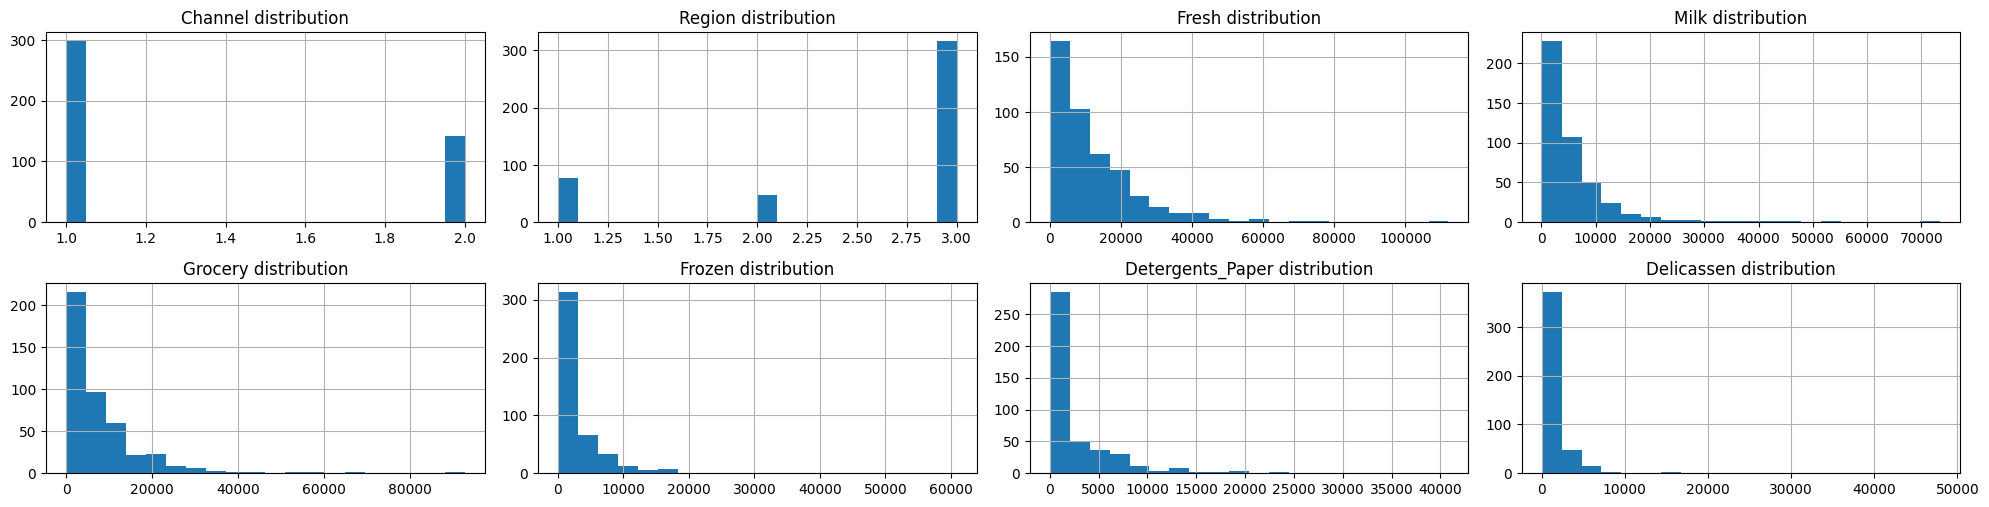

In [86]:
import matplotlib.pyplot as plt

# Plot the histograms for all columns
fig = plt.figure(figsize=(20, 20))

for i, feature in enumerate(wholesale_df.columns):
    ax = fig.add_subplot(8, 4, i + 1)
    wholesale_df[feature].hist(bins=20, ax=ax)
    ax.set_title(feature + ' distribution')

fig.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [87]:
#Describe the data
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


By ploting and describing our dataset, we can notice that both "Channel" and "Region" are categorical, we will drop them to prevent any potential clustering issues. But first, what do these columns represent and is there key data we can observe from them?

Customer count per each channel type:
 Channel
1    298
2    142
Name: count, dtype: int64

Percentage of customers per channel type:
 Channel
HORECA    67.727273
Retail    32.272727
Name: proportion, dtype: float64


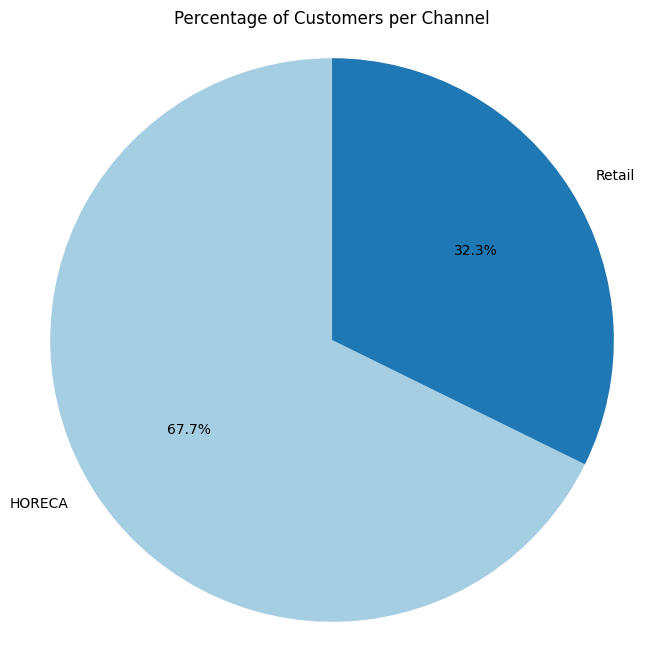

In [88]:
# Calculate counts and percentages of customers per channel type
def calculate_channel_stats(df, column_name):
    counts = df[column_name].value_counts().sort_values(ascending=False)
    percentages = df[column_name].value_counts(normalize=True).sort_values(ascending=False) * 100
    return counts, percentages

# Get channel statistics
counts, percentages = calculate_channel_stats(df, 'Channel')
percentages.index = percentages.index.map({1: 'HORECA', 2: 'Retail'})

# Display
print('Customer count per each channel type:\n', counts)
print('\nPercentage of customers per channel type:\n', percentages)

# Plot percentage of customers per channel type as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Percentage of Customers per Channel')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show both pie charts
plt.show()

After percentage of customers, we can see that 67.7% of customers are HORECA, while only 32.3% are retail customers. From the additional variable information, we see that Horeca customers are representing Hotels, Restaurants, and Cafes, vs retail which individuals. 

In [89]:
# Drop specific columns by name
df = df.drop(columns=['Channel', 'Region'])

In [90]:
#making sure that there are no null values
print(df.isnull().sum())

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [91]:
#need to remove outliers for even distribution

def remove_outliers(dataframe, col):

    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]

for col in df.columns:
    df = remove_outliers(df, col)

df.drop_duplicates(inplace=True)

df.shape

(318, 6)

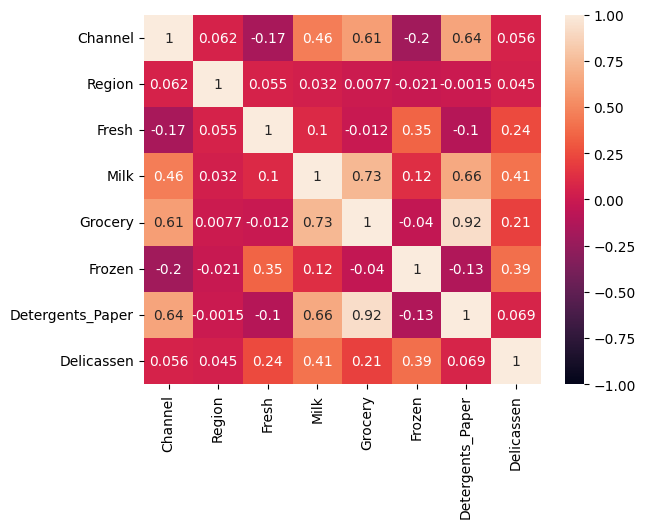

In [97]:
#plot heatmap to see relationships
heatmap = sns.heatmap(wholesale_df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Plotting out our diagram onto a heatmap shows strong relationships between certain items, such as Milk and Grocery, or Channel and Detergent Paper. This can be useful to the wholesale vender in determining potential correlations between their customers and certain products.

## Part 2: Hierachical Clustering

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of clusters. It is an unsupervised learning technique used to group similar objects into clusters based on their distances from one another. Hierarchical clustering works by either successively merging smaller clusters (agglomerative) or successively dividing larger clusters (divisive).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


     Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  Cluster
0    12669  9656     7561     214              2674        1338        1
1     7057  9810     9568    1762              3293        1776        1
3    13265  1196     4221    6404               507        1788        0
5     9413  8259     5126     666              1795        1451        1
6    12126  3199     6975     480              3140         545        0
..     ...   ...      ...     ...               ...         ...      ...
432  21117  1162     4754     269              1328         395        0
433   1982  3218     1493    1541               356        1449        0
434  16731  3922     7994     688              2371         838        0
438  10290  1981     2232    1038               168        2125        0
439   2787  1698     2510      65               477          52        0

[318 rows x 7 columns]


Text(0, 0.5, 'Euclidean distance')

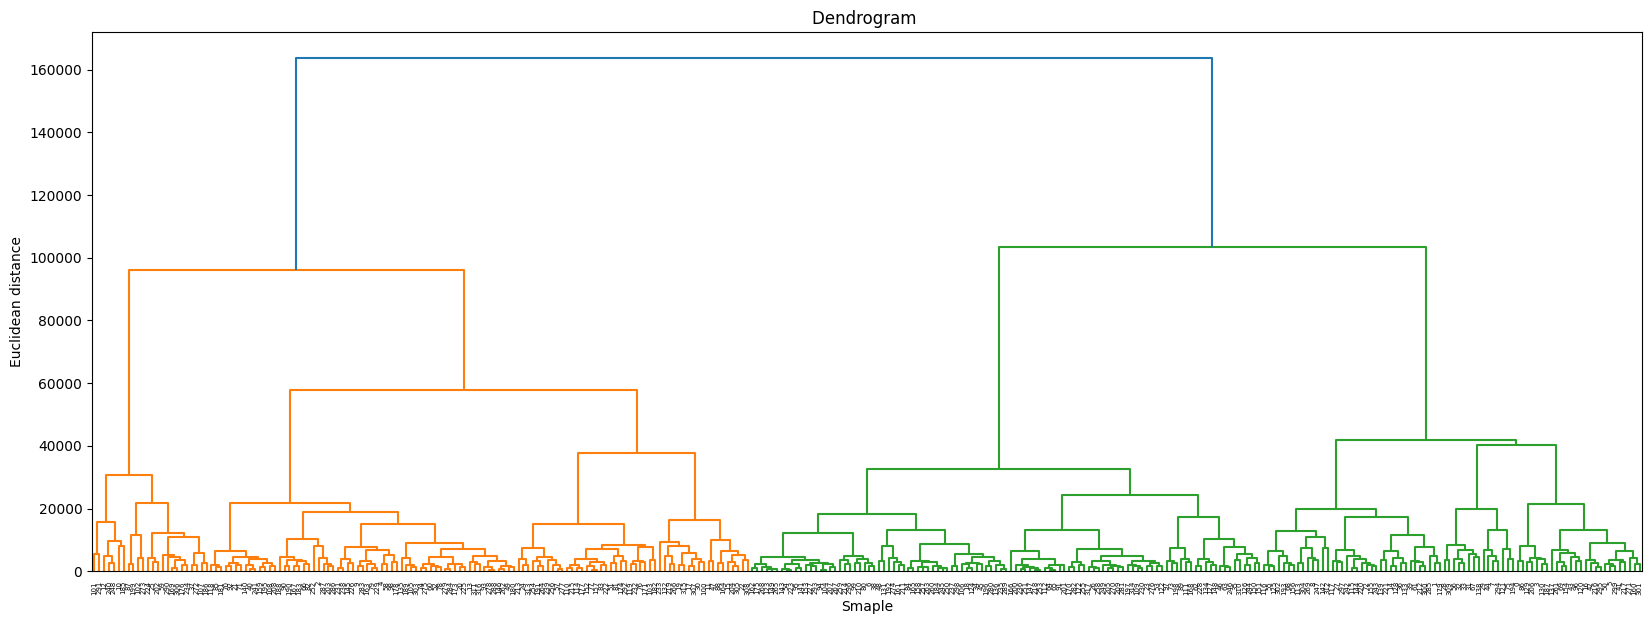

In [120]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Applying Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_labels = agg_clust.fit_predict(X_scaled)

# Add the cluster labels to your original data
df['Cluster'] = cluster_labels

# View the results
print(df)

#plot dendrogram

plt.figure(figsize=(20,7))
plt.title("Dendrogram ")

#create dendrogram
sc.dendrogram(sc.linkage(X,method='ward'))
plt.title("Dendrogram ")
plt.xlabel('Smaple')
plt.ylabel("Euclidean distance")

Considering the distribution, a good chunk of the customers are in the same clusters despite changing the features which indicates that these customers share consistent patterns or behaviors across different sets of features. This suggests that customers are distinct in a way that the features capture. This can also mean that the customers grouped together might share characteristics that remain strong across different feature sets.

## Part 3: PCA

Principal Component Analysis (PCA) is often used for dimensionality reduction. It helps reduce the number of features (dimensions) in a dataset while retaining as much of the original data's variability as possible.

Eigenvalues:
[67915181.65567322 31687377.034024    3726409.08781365  2403647.27309039
  1093630.07342841   506582.75783243]

Variances (Percentage):
[63.27531194 29.52253999  3.47182606  2.23943347  1.0189148   0.47197374]



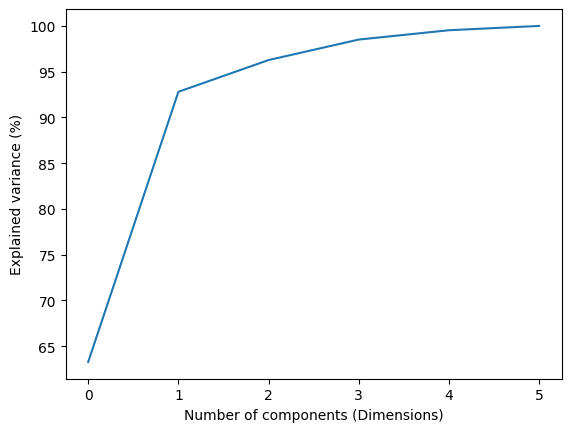

In [130]:
# Using PCA
pca = PCA(n_components=None)
pca.fit(X)

# Get the eigenvalues
print('Eigenvalues:')
print(pca.explained_variance_)
print()

# Get explained variances
print('Variances (Percentage):')
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components (Dimensions)')
plt.ylabel('Explained variance (%)')
plt.show()

In [131]:
# Take the abs of pca.components_
pca_components = abs(pca.components_)
print(pca_components)

[[0.99204378 0.04779889 0.0782173  0.04338874 0.07235791 0.01811639]
 [0.11203433 0.49229865 0.79358592 0.05298442 0.33240938 0.04481518]
 [0.00819694 0.8656412  0.47891484 0.03448479 0.13580874 0.04006853]
 [0.03624651 0.00763826 0.04264149 0.99412117 0.07246197 0.05728792]
 [0.04134331 0.04422284 0.35699589 0.04149402 0.91817118 0.1553349 ]
 [0.01439355 0.06331369 0.07402472 0.06420441 0.13242079 0.98419869]]


In [143]:
# Get the components from PCA
pca_components = pca.components_

print('Features in importance sequence')

for row in range(pca_components.shape[0]):
    indices = np.argsort(np.abs(pca_components[row]))[::-1][:8]
    print(f'Component {row}: {df.columns[indices].to_list()}')

Features in importance sequence
Component 0: ['Fresh', 'Grocery', 'Detergents_Paper', 'Milk', 'Frozen', 'Delicassen']
Component 1: ['Grocery', 'Milk', 'Detergents_Paper', 'Fresh', 'Frozen', 'Delicassen']
Component 2: ['Milk', 'Grocery', 'Detergents_Paper', 'Delicassen', 'Frozen', 'Fresh']
Component 3: ['Frozen', 'Detergents_Paper', 'Delicassen', 'Grocery', 'Fresh', 'Milk']
Component 4: ['Detergents_Paper', 'Grocery', 'Delicassen', 'Milk', 'Frozen', 'Fresh']
Component 5: ['Delicassen', 'Detergents_Paper', 'Grocery', 'Frozen', 'Milk', 'Fresh']


In [146]:
# Apply PCA again with n_components=3
pca2 = PCA(n_components=3)
X_pca = pca2.fit_transform(X)

X_pca = pd.DataFrame(X_pca)
X_pca.head()

,0,1,2
0,2377.570553,5082.307166,3771.016517
1,-3323.811094,6265.481986,2976.011256
2,4067.981344,-2694.481734,-1431.828618
3,-510.028356,1786.327775,3894.053389
4,2156.819869,1482.929295,-1619.221925


## Part 4: Discussion / Conclusion

From our analysis, we found that most wholesale customers are from the Horeca sector (hotels, restaurants, etc.), not from regular retail customers. This mirrors real life, where hotels and businesses often buy products from wholesalers instead of commercial stores. The company sells to only a few customer categories: Lisbon, Oporto, and Other. This suggests that the vendor's customer base is limited by geography and might benefit from expanding to new areas.

We used Hierarchical Clustering to group customers based on their buying habits and attributes. When we tested different sets of features, we found that most customers were consistently placed in the same clusters. This shows that Hierarchical Clustering is less affected by changing the features compared to other methods.

Principal Component Analysis helped identify the most important features that describe customers. We see:
Component 0: ['Fresh', 'Grocery', 'Detergents_Paper', 'Milk', 'Frozen', 'Delicassen']
Component 1: ['Grocery', 'Milk', 'Detergents_Paper', 'Fresh', 'Frozen', 'Delicassen']
Component 2: ['Milk', 'Grocery', 'Detergents_Paper', 'Delicassen', 'Frozen', 'Fresh']
Component 3: ['Frozen', 'Detergents_Paper', 'Delicassen', 'Grocery', 'Fresh', 'Milk']
Component 4: ['Detergents_Paper', 'Grocery', 'Delicassen', 'Milk', 'Frozen', 'Fresh']
Component 5: ['Delicassen', 'Detergents_Paper', 'Grocery', 'Frozen', 'Milk', 'Fresh']

as the more common relationships